In [208]:
import pandas as pd
import matplotlib.pyplot as plt
from pymongo import MongoClient
import joblib
import json
from dotenv import load_dotenv
import os
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,f1_score,recall_score,roc_auc_score,roc_curve,classification_report
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [41]:
load_dotenv()

True

## Data Exploration

In [4]:
df = pd.read_csv('heart_disease_uci.csv')
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [5]:
df.shape

(920, 16)

### Checking the age distribution

Text(0.5, 1.0, 'Age distribution')

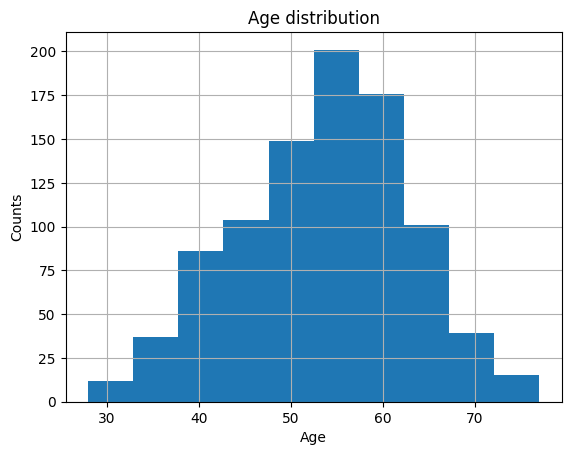

In [10]:
df['age'].hist()
plt.xlabel('Age')
plt.ylabel('Counts')
plt.title('Age distribution')

<Axes: xlabel='sex'>

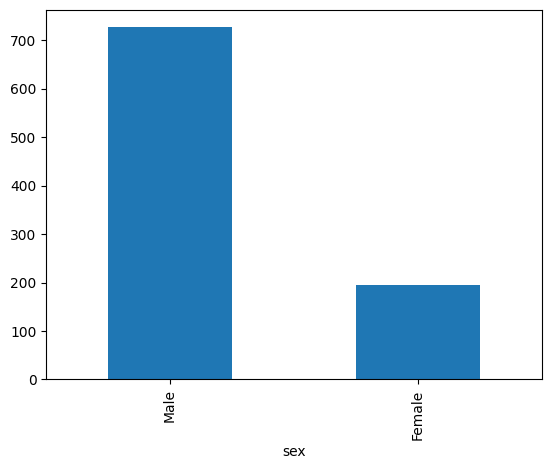

In [14]:
df['sex'].value_counts().plot(kind='bar')

In [15]:
# update the target colums
df['target'] = df['num'].apply(lambda num: 1 if num>0 else 0)
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num,target
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2,1
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0,0


<Axes: xlabel='target'>

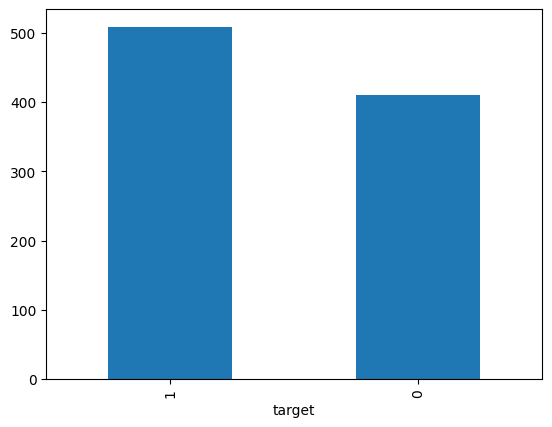

In [16]:
df['target'].value_counts().plot(kind='bar')

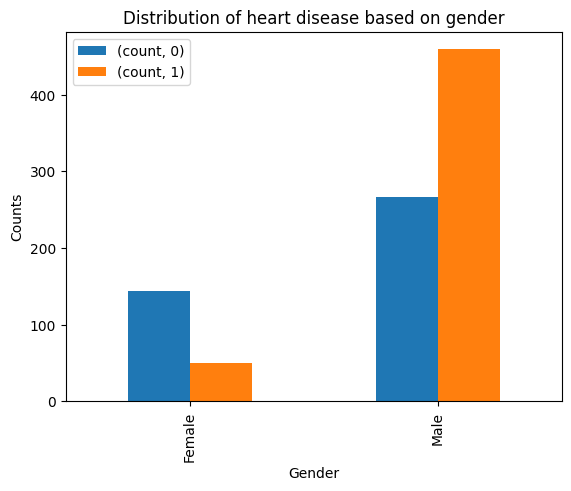

In [24]:
df.groupby(['sex','target']).size()\
.reset_index(name='count')\
.pivot(index='sex',columns='target')\
.plot(kind='bar')

plt.xlabel('Gender')
plt.ylabel('Counts')
plt.title('Distribution of heart disease based on gender')
plt.legend()

## Medallion Architecture

### Bronze Layer

In [27]:
# Storing the raw csv data as JSON in a MongoDB collection 
# heart_disease_bronze -> in DB healthcare

In [28]:
df.to_json("heart_disease_bronze.json",orient="records",lines=False)

In [42]:
uri = os.getenv("MONGO_URI")
client=MongoClient(uri,tlsAllowInvalidCertificates=True)
db=client['healthcare']
collection=db['heart_disease_bronze']

In [43]:
#inserting each json object into healthcare db in heart_disease_bronze collection
with open('heart_disease_bronze.json','r') as file:
    data = json.load(file)

for item in data:
    collection.insert_one(item)

In [86]:
def push_to_mongodb(df,collection_name):
    df.to_json(f'{collection_name}.json',orient="records",lines=False)
    uri = os.getenv("MONGO_URI")
    client=MongoClient(uri,tlsAllowInvalidCertificates=True)
    db=client['healthcare']
    collection=db[collection_name]

    with open(f'{collection_name}.json','r') as file:
        data = json.load(file)
    
    for item in data:
        collection.insert_one(item)

### Silver Layer

In [45]:
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num,target
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2,1
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0,0


In [46]:
df.isna().sum()

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
target        0
dtype: int64

In [57]:
numeric_cols = ['trestbps','chol','thalch','oldpeak']
cols_to_remove = ['slope','ca','thal']
categorical_cols = ['fbs','restecg','exang']

<Axes: xlabel='dataset'>

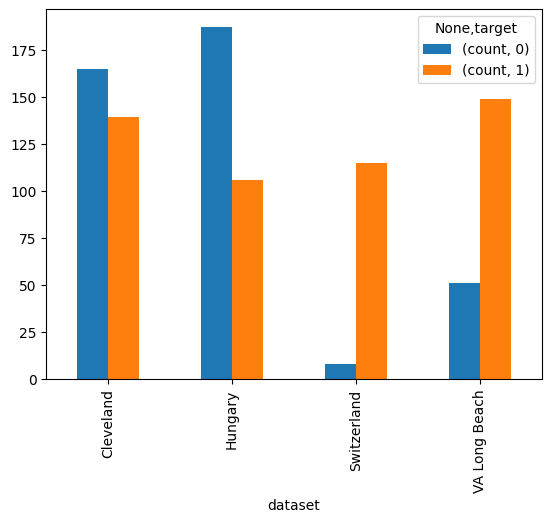

In [56]:
df.groupby(['dataset','target']).size().reset_index(name='count')\
.pivot(index='dataset',columns='target')\
.plot(kind='bar')

In [58]:
df_cols_remove = df.drop(columns=cols_to_remove)

In [62]:
df_cols_remove[numeric_cols].describe()

,trestbps,chol,thalch,oldpeak
count,861.000000,890.000000,865.000000,858.000000
mean,132.132404,199.130337,137.545665,0.878788
std,19.066070,110.780810,25.926276,1.091226
min,0.000000,0.000000,60.000000,-2.600000
25%,120.000000,175.000000,120.000000,0.000000
50%,130.000000,223.000000,140.000000,0.500000
75%,140.000000,268.000000,157.000000,1.500000
max,200.000000,603.000000,202.000000,6.200000


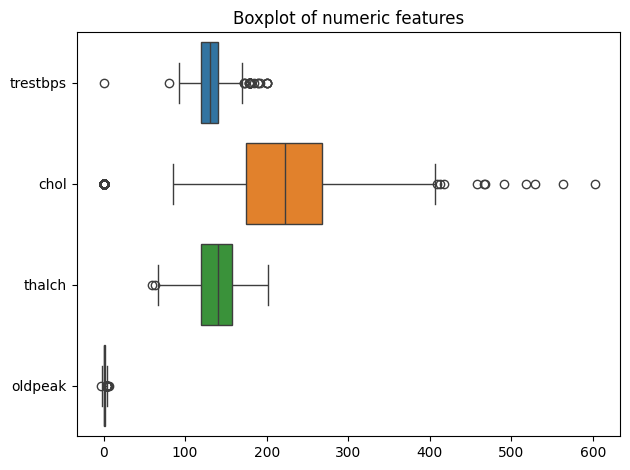

In [65]:
#plotting boxplot to check for outliers in data
sns.boxplot(data=df[numeric_cols], orient='h')
plt.title('Boxplot of numeric features')
plt.tight_layout()
plt.show()

In [68]:
#since there are outliers as shown above, median imputation is a better choice for numeric cols
median_imputer = SimpleImputer(strategy='median')
mode_imputer = SimpleImputer(strategy='most_frequent')
df_silver = df_cols_remove.copy()
df_silver[numeric_cols] = median_imputer.fit_transform(df_silver[numeric_cols])
df_silver[categorical_cols] = mode_imputer.fit_transform(df_silver[categorical_cols])

In [69]:
df_silver.isna().sum()

id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
num         0
target      0
dtype: int64

In [71]:
df_silver.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,num,target
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,0,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,2,1
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,1,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,0,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,0,0


In [77]:
# now converting categorical
categorical_cols_all=['sex','dataset','cp','fbs','restecg','exang']
encoded_df = pd.get_dummies(df_silver,columns=categorical_cols_all,drop_first=True)

In [78]:
encoded_df.head()

,id,age,trestbps,chol,thalch,oldpeak,num,target,sex_Male,dataset_Hungary,dataset_Switzerland,dataset_VA Long Beach,cp_atypical angina,cp_non-anginal,cp_typical angina,fbs_True,restecg_normal,restecg_st-t abnormality,exang_True
0,1,63,145.0,233.0,150.0,2.3,0,0,True,False,False,False,False,False,True,True,False,False,False
1,2,67,160.0,286.0,108.0,1.5,2,1,True,False,False,False,False,False,False,False,False,False,True
2,3,67,120.0,229.0,129.0,2.6,1,1,True,False,False,False,False,False,False,False,False,False,True
3,4,37,130.0,250.0,187.0,3.5,0,0,True,False,False,False,False,True,False,False,True,False,False
4,5,41,130.0,204.0,172.0,1.4,0,0,False,False,False,False,True,False,False,False,False,False,False


In [80]:
bool_cols = encoded_df.select_dtypes(include='bool').columns  # Select bool columns
encoded_df[bool_cols] = encoded_df[bool_cols].astype(int)

In [82]:
df_silver = encoded_df.copy()

In [83]:
df_silver.head()

,id,age,trestbps,chol,thalch,oldpeak,num,target,sex_Male,dataset_Hungary,dataset_Switzerland,dataset_VA Long Beach,cp_atypical angina,cp_non-anginal,cp_typical angina,fbs_True,restecg_normal,restecg_st-t abnormality,exang_True
0,1,63,145.0,233.0,150.0,2.3,0,0,1,0,0,0,0,0,1,1,0,0,0
1,2,67,160.0,286.0,108.0,1.5,2,1,1,0,0,0,0,0,0,0,0,0,1
2,3,67,120.0,229.0,129.0,2.6,1,1,1,0,0,0,0,0,0,0,0,0,1
3,4,37,130.0,250.0,187.0,3.5,0,0,1,0,0,0,0,1,0,0,1,0,0
4,5,41,130.0,204.0,172.0,1.4,0,0,0,0,0,0,1,0,0,0,0,0,0


In [87]:
#now pushing to mongo db
push_to_mongodb(df_silver,'heart_disease_silver')

## Gold Layer

In [91]:
df_gold = df_silver.drop(columns=['id','num'],axis=1)
df_gold.head()

,age,trestbps,chol,thalch,oldpeak,target,sex_Male,dataset_Hungary,dataset_Switzerland,dataset_VA Long Beach,cp_atypical angina,cp_non-anginal,cp_typical angina,fbs_True,restecg_normal,restecg_st-t abnormality,exang_True
0,63,145.0,233.0,150.0,2.3,0,1,0,0,0,0,0,1,1,0,0,0
1,67,160.0,286.0,108.0,1.5,1,1,0,0,0,0,0,0,0,0,0,1
2,67,120.0,229.0,129.0,2.6,1,1,0,0,0,0,0,0,0,0,0,1
3,37,130.0,250.0,187.0,3.5,0,1,0,0,0,0,1,0,0,1,0,0
4,41,130.0,204.0,172.0,1.4,0,0,0,0,0,1,0,0,0,0,0,0


In [92]:
numeric_cols_to_scale=['age','trestbps','chol','thalch','oldpeak']
scaler = MinMaxScaler()
df_gold[numeric_cols_to_scale] = scaler.fit_transform(df_gold[numeric_cols_to_scale])

In [93]:
df_gold.head()

,age,trestbps,chol,thalch,oldpeak,target,sex_Male,dataset_Hungary,dataset_Switzerland,dataset_VA Long Beach,cp_atypical angina,cp_non-anginal,cp_typical angina,fbs_True,restecg_normal,restecg_st-t abnormality,exang_True
0,0.714286,0.725,0.386401,0.633803,0.556818,0,1,0,0,0,0,0,1,1,0,0,0
1,0.795918,0.800,0.474295,0.338028,0.465909,1,1,0,0,0,0,0,0,0,0,0,1
2,0.795918,0.600,0.379768,0.485915,0.590909,1,1,0,0,0,0,0,0,0,0,0,1
3,0.183673,0.650,0.414594,0.894366,0.693182,0,1,0,0,0,0,1,0,0,1,0,0
4,0.265306,0.650,0.338308,0.788732,0.454545,0,0,0,0,0,1,0,0,0,0,0,0


In [101]:
#pushing this refined dataset to the gold layer
push_to_mongodb(df_gold,'heart_disease_gold')

### Feature selection based on correlation

In [98]:
correlation_matrix = df_gold.corr(numeric_only=True)

cor_with_target = correlation_matrix['target'].abs().sort_values(ascending=False)

top_features = cor_with_target.drop('target').head(20)

print("Top correlated features:\n", top_features)


Top correlated features:
 exang_True                  0.433605
cp_atypical angina          0.403465
thalch                      0.381864
oldpeak                     0.366138
sex_Male                    0.307284
dataset_Switzerland         0.301614
age                         0.282700
dataset_Hungary             0.263297
chol                        0.228976
cp_non-anginal              0.209812
dataset_VA Long Beach       0.203267
fbs_True                    0.108071
restecg_st-t abnormality    0.104750
trestbps                    0.101273
restecg_normal              0.093554
cp_typical angina           0.054673
Name: target, dtype: float64


In [206]:
for feature,_ in top_features.items():
    if "dataset" not in feature:
        print(feature)

exang_True
cp_atypical angina
thalch
oldpeak
sex_Male
age
chol
cp_non-anginal
fbs_True
restecg_st-t abnormality
trestbps
restecg_normal
cp_typical angina


In [248]:
features = []
for feature,corr in top_features.items():
    if corr>=0.10 and "dataset" not in feature:
        features.append(feature)

In [249]:
print(features)

['exang_True', 'cp_atypical angina', 'thalch', 'oldpeak', 'sex_Male', 'age', 'chol', 'cp_non-anginal', 'fbs_True', 'restecg_st-t abnormality', 'trestbps']


## Machine Learning Model Development

In [250]:
X=df_gold.drop('target',axis=1)
y=df_gold['target']

In [251]:
X.head()

,age,trestbps,chol,thalch,oldpeak,sex_Male,dataset_Hungary,dataset_Switzerland,dataset_VA Long Beach,cp_atypical angina,cp_non-anginal,cp_typical angina,fbs_True,restecg_normal,restecg_st-t abnormality,exang_True
0,0.714286,0.725,0.386401,0.633803,0.556818,1,0,0,0,0,0,1,1,0,0,0
1,0.795918,0.800,0.474295,0.338028,0.465909,1,0,0,0,0,0,0,0,0,0,1
2,0.795918,0.600,0.379768,0.485915,0.590909,1,0,0,0,0,0,0,0,0,0,1
3,0.183673,0.650,0.414594,0.894366,0.693182,1,0,0,0,0,1,0,0,1,0,0
4,0.265306,0.650,0.338308,0.788732,0.454545,0,0,0,0,1,0,0,0,0,0,0


In [252]:
X=X[features]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [253]:
model=LogisticRegression()

In [254]:
def plot_roc_auc(model,X_test,y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()
    

In [255]:
def evaluate_model(model,X_train,y_train,X_test,y_test):
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    print(classification_report(y_test,y_pred))
    plot_roc_auc(model,X_test,y_test)

              precision    recall  f1-score   support

           0       0.75      0.81      0.78        75
           1       0.86      0.82      0.84       109

    accuracy                           0.82       184
   macro avg       0.81      0.81      0.81       184
weighted avg       0.82      0.82      0.82       184



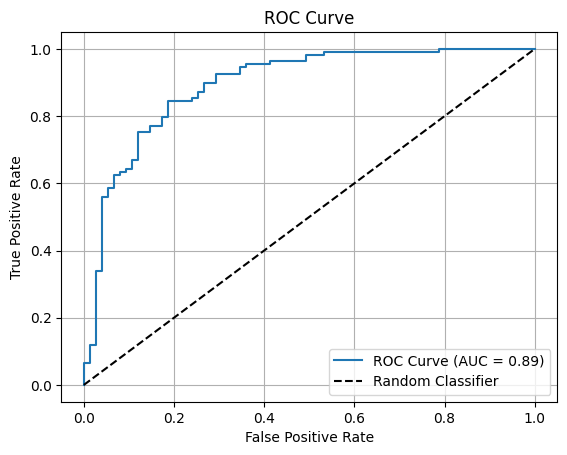

In [256]:
evaluate_model(model,X_train,y_train,X_test,y_test)

              precision    recall  f1-score   support

           0       0.78      0.83      0.81        75
           1       0.88      0.84      0.86       109

    accuracy                           0.84       184
   macro avg       0.83      0.84      0.83       184
weighted avg       0.84      0.84      0.84       184



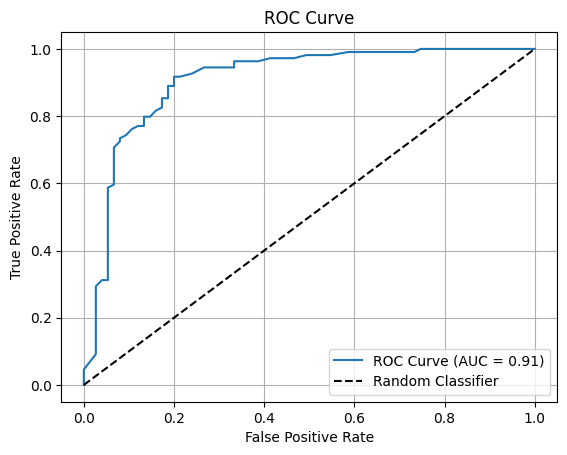

In [257]:
random_forest = RandomForestClassifier(n_estimators=100)
evaluate_model(random_forest,X_train,y_train,X_test,y_test)

In [258]:
def find_best_model(model,param_grid,X_train,y_train):
    grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=5,                    
                           scoring='roc_auc',            
                           verbose=1,
                           n_jobs=-1)              

    grid_search.fit(X_train, y_train)

    # 5. Best model and parameters
    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)

In [259]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],           # Number of trees in the forest
    'max_depth': [10, 20, 30],           # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],           # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],             # Minimum samples required at each leaf node  # Number of features to consider at each split
}
find_best_model(random_forest,param_grid_rf,X_train,y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best score: 0.8791862379280071


              precision    recall  f1-score   support

           0       0.82      0.84      0.83        75
           1       0.89      0.87      0.88       109

    accuracy                           0.86       184
   macro avg       0.85      0.86      0.85       184
weighted avg       0.86      0.86      0.86       184



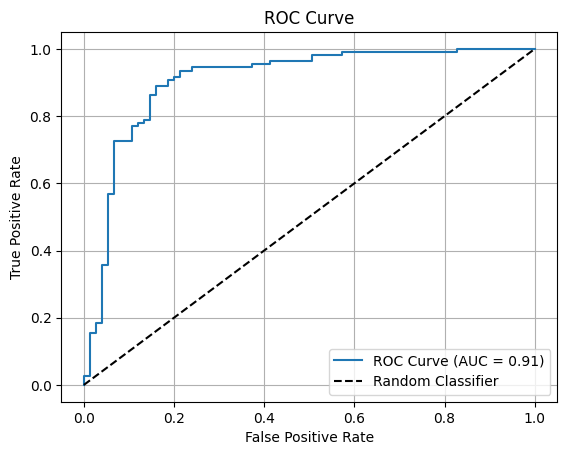

In [260]:
best_random_forest=RandomForestClassifier(max_depth=10,min_samples_leaf=4,min_samples_split=10,n_estimators=100)
evaluate_model(best_random_forest,X_train,y_train,X_test,y_test)

              precision    recall  f1-score   support

           0       0.78      0.83      0.80        75
           1       0.88      0.83      0.85       109

    accuracy                           0.83       184
   macro avg       0.82      0.83      0.83       184
weighted avg       0.83      0.83      0.83       184



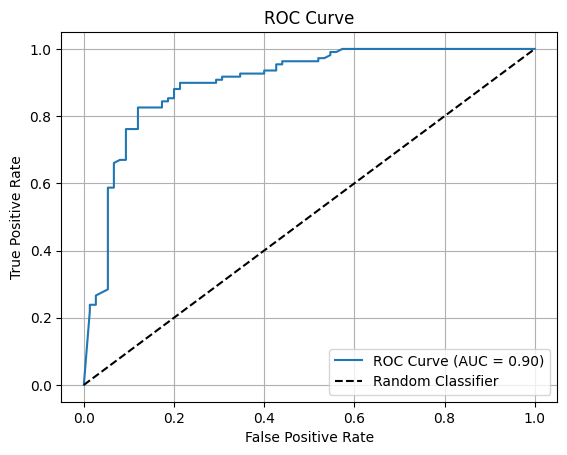

In [261]:
adaboost = AdaBoostClassifier(n_estimators=200,learning_rate=0.01,estimator=DecisionTreeClassifier(max_depth=5))
evaluate_model(adaboost,X_train,y_train,X_test,y_test)

              precision    recall  f1-score   support

           0       0.78      0.79      0.78        75
           1       0.85      0.84      0.85       109

    accuracy                           0.82       184
   macro avg       0.81      0.82      0.81       184
weighted avg       0.82      0.82      0.82       184



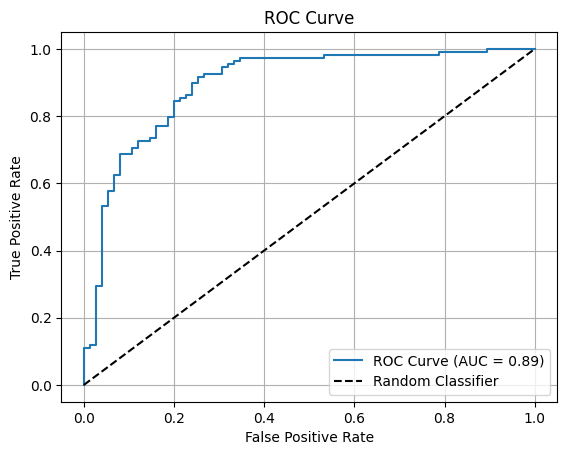

In [262]:
svm_model =  SVC(probability=True)
evaluate_model(svm_model,X_train,y_train,X_test,y_test)

In [263]:
param_grid = {
    'C': [0.1, 1, 10, 100],                         # Regularization strength
    'kernel': ['linear', 'rbf', 'poly'],            # Different kernel functions
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],       # Kernel coefficient
    'degree': [2, 3, 4],                            # Only used if kernel='poly'
    'probability': [True]                           # Needed for ROC curve or predict_proba
}
find_best_model(SVC(),param_grid,X_train,y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'probability': True}
Best score: 0.873484964881475


              precision    recall  f1-score   support

           0       0.72      0.81      0.76        75
           1       0.86      0.78      0.82       109

    accuracy                           0.79       184
   macro avg       0.79      0.80      0.79       184
weighted avg       0.80      0.79      0.79       184



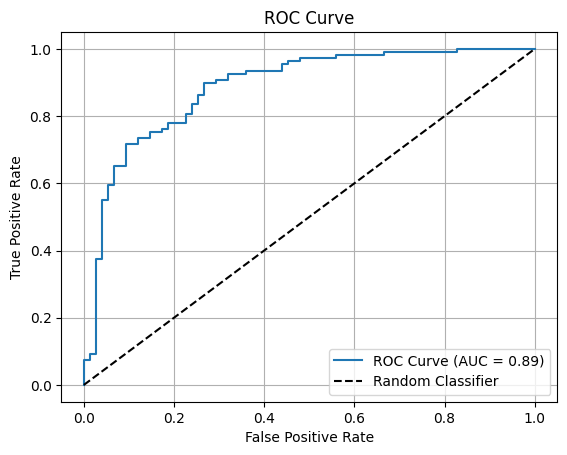

In [264]:
best_svc_model = SVC(C=100,degree=2,gamma='scale',kernel='linear',probability=True)
evaluate_model(best_svc_model,X_train,y_train,X_test,y_test)

## Best Model: RandomForest Classifier
* This model performs better because it reduces overfitting compared to a single decision tree, which tends to memorize the training
* Even with small datasets, Random Forest provides generalization by averaging many weak learners
* It can capture non linear patterns unlike logistic regression
* It it interpretable



In [267]:
joblib.dump(best_random_forest,'model.pkl')

['model.pkl']

In [277]:
joblib.dump(scaler,'scaler.pkl')

['scaler.pkl']

In [268]:
print(features)

['exang_True', 'cp_atypical angina', 'thalch', 'oldpeak', 'sex_Male', 'age', 'chol', 'cp_non-anginal', 'fbs_True', 'restecg_st-t abnormality', 'trestbps']


In [279]:
df_silver.head()

,id,age,trestbps,chol,thalch,oldpeak,num,target,sex_Male,dataset_Hungary,dataset_Switzerland,dataset_VA Long Beach,cp_atypical angina,cp_non-anginal,cp_typical angina,fbs_True,restecg_normal,restecg_st-t abnormality,exang_True
0,1,63,145.0,233.0,150.0,2.3,0,0,1,0,0,0,0,0,1,1,0,0,0
1,2,67,160.0,286.0,108.0,1.5,2,1,1,0,0,0,0,0,0,0,0,0,1
2,3,67,120.0,229.0,129.0,2.6,1,1,1,0,0,0,0,0,0,0,0,0,1
3,4,37,130.0,250.0,187.0,3.5,0,0,1,0,0,0,0,1,0,0,1,0,0
4,5,41,130.0,204.0,172.0,1.4,0,0,0,0,0,0,1,0,0,0,0,0,0


In [281]:
joblib.dump(X_train.columns.tolist(),"feature_names.pkl")

['feature_names.pkl']